# Libraries

In [39]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
import seaborn as sns


# Loading Datasets

In [40]:
bank_rate = pd.read_csv("bank_rate.csv")
bank_rate['Date'] = pd.to_datetime(bank_rate['Date'], format="%d-%m-%Y")
print(bank_rate.head())


cpih = pd.read_csv("cpih_monthly.csv", skiprows=187, header=None)
cpih = cpih[0].str.split(',', expand=True)
cpih.columns = ['Date', 'CPIH_Rate']
cpih['Date'] = pd.to_datetime(cpih['Date'], format="%Y %b", errors='coerce')

print(cpih.head())


gdp = pd.read_csv("gdp_monthly.csv", skiprows=7, header=None)
gdp = gdp[0].str.split(',', expand=True)
gdp.columns = ['Date', 'GDP_Rate']
gdp['Date'] = pd.to_datetime(gdp['Date'], format="%b %Y", errors='coerce')
print(gdp.head())


        Date  Bank Rate
0 2001-12-03        4.0
1 2001-12-04        4.0
2 2001-12-05        4.0
3 2001-12-06        4.0
4 2001-12-07        4.0
        Date CPIH_Rate
0 1989-02-01     "5.8"
1 1989-03-01     "5.9"
2 1989-04-01     "5.6"
3 1989-05-01     "5.9"
4 1989-06-01     "5.8"
        Date GDP_Rate
0 2007-01-01   "82.9"
1 2007-02-01   "83.2"
2 2007-03-01   "83.3"
3 2007-04-01   "83.5"
4 2007-05-01   "83.9"


In [41]:
gbp_usd = yf.download("GBPUSD=X", start="2000-01-01", end="2023-01-01")
gbp_usd.columns = gbp_usd.columns.get_level_values(0)
gbp_usd = gbp_usd.reset_index()[['Date', 'Close']].rename(columns={'Close': 'Gbp_usd.Close'})

print(gbp_usd.head())

[*********************100%***********************]  1 of 1 completed

Price       Date  Gbp_usd.Close
0     2003-12-01       1.718597
1     2003-12-02       1.730313
2     2003-12-03       1.728101
3     2003-12-04       1.720697
4     2003-12-05       1.733102


# FTSE and VIX data from Yahoo Finance

In [42]:
ftse = yf.download("^FTSE", start="2000-01-01", end="2024-08-31")
ftse.columns = ftse.columns.get_level_values(0)
ftse = ftse.reset_index()[['Date', 'Close']].rename(columns={'Close': 'FTSE.Close'})
vix = yf.download("^VIX", start="2000-01-01", end="2024-08-31")
vix.columns = vix.columns.get_level_values(0)
vix = vix.reset_index()[['Date', 'Close']].rename(columns={'Close': 'VIX.Close'})
print(ftse.head())
print(vix.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price       Date   FTSE.Close
0     2000-01-04  6665.899902
1     2000-01-05  6535.899902
2     2000-01-06  6447.200195
3     2000-01-07  6504.799805
4     2000-01-10  6607.700195
Price       Date  VIX.Close
0     2000-01-03  24.209999
1     2000-01-04  27.010000
2     2000-01-05  26.410000
3     2000-01-06  25.730000
4     2000-01-07  21.719999


#Date Range and Datetime

In [43]:
start_date = "2007-01-01"
end_date = "2024-08-31"

bank_rate = bank_rate[(bank_rate['Date'] >= start_date) & (bank_rate['Date'] <= end_date)]
cpih = cpih[(cpih['Date'] >= start_date) & (cpih['Date'] <= end_date)]
gdp = gdp[(gdp['Date'] >= start_date) & (gdp['Date'] <= end_date)]
ftse = ftse[(ftse['Date'] >= start_date) & (ftse['Date'] <= end_date)]
vix = vix[(vix['Date'] >= start_date) & (vix['Date'] <= end_date)]
gbp_usd = gbp_usd[(gbp_usd['Date'] >= start_date) & (gbp_usd['Date'] <= end_date)]

bank_rate['Date'] = pd.to_datetime(bank_rate['Date']).dt.tz_localize(None)
cpih['Date'] = pd.to_datetime(cpih['Date']).dt.tz_localize(None)
gdp['Date'] = pd.to_datetime(gdp['Date']).dt.tz_localize(None)
ftse['Date'] = pd.to_datetime(ftse['Date']).dt.tz_localize(None)
vix['Date'] = pd.to_datetime(vix['Date']).dt.tz_localize(None)
gbp_usd['Date'] = pd.to_datetime(gbp_usd['Date']).dt.tz_localize(None)




<ipython-input-43-02cb0c78cf26>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bank_rate['Date'] = pd.to_datetime(bank_rate['Date']).dt.tz_localize(None)
<ipython-input-43-02cb0c78cf26>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpih['Date'] = pd.to_datetime(cpih['Date']).dt.tz_localize(None)
<ipython-input-43-02cb0c78cf26>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [44]:
#frequency of variables
print(f"Filtered {start_date} to {end_date}, remaining rows:")
print(bank_rate.shape, cpih.shape, gdp.shape, ftse.shape, vix.shape)

print("Bank Rate frequency:", pd.infer_freq(bank_rate['Date']))
print("CPIH frequency:", pd.infer_freq(cpih['Date']))
print("GDP frequency:", pd.infer_freq(gdp['Date']))
print("FTSE frequency:", pd.infer_freq(ftse['Date']))
print("VIX frequency:", pd.infer_freq(vix['Date']))
print("gbp_/usd frequency:", pd.infer_freq(gbp_usd['Date']))

Filtered 2007-01-01 to 2024-08-31, remaining rows:
(4463, 2) (212, 2) (212, 2) (4461, 2) (4446, 2)
Bank Rate frequency: None
CPIH frequency: MS
GDP frequency: MS
FTSE frequency: None
VIX frequency: None
gbp_/usd frequency: None


In [45]:
cpih['CPIH_Rate'] = pd.to_numeric(cpih['CPIH_Rate'].str.replace('"', ''), errors='coerce')
print("CPIH Dataset after conversion:")
print(cpih.head())


CPIH Dataset after conversion:
          Date  CPIH_Rate
215 2007-01-01        2.7
216 2007-02-01        2.7
217 2007-03-01        2.9
218 2007-04-01        2.7
219 2007-05-01        2.5


In [46]:
gdp['GDP_Rate'] = pd.to_numeric(gdp['GDP_Rate'].str.replace('"', ''), errors='coerce')
print("GDP Dataset after conversion:")
print(gdp.head())


GDP Dataset after conversion:
        Date  GDP_Rate
0 2007-01-01      82.9
1 2007-02-01      83.2
2 2007-03-01      83.3
3 2007-04-01      83.5
4 2007-05-01      83.9


In [47]:
#setting frequeny to monthly
bank_rate = bank_rate.set_index('Date').resample('M').mean().reset_index()
ftse = ftse.set_index('Date').resample('M').mean().reset_index()
vix = vix.set_index('Date').resample('M').mean().reset_index()
gdp = gdp.set_index('Date').resample('M').mean().reset_index()
gbp_usd = gbp_usd.set_index('Date').resample('M').mean().reset_index()
cpih = cpih.set_index('Date').resample('M').mean().reset_index()


<ipython-input-47-7f468e1549b0>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  bank_rate = bank_rate.set_index('Date').resample('M').mean().reset_index()
<ipython-input-47-7f468e1549b0>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ftse = ftse.set_index('Date').resample('M').mean().reset_index()
<ipython-input-47-7f468e1549b0>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vix = vix.set_index('Date').resample('M').mean().reset_index()
<ipython-input-47-7f468e1549b0>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gdp = gdp.set_index('Date').resample('M').mean().reset_index()
<ipython-input-47-7f468e1549b0>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gbp_usd = gbp_usd.set_index('Date').resample('M').mean

In [48]:
print(f"Filtered {start_date} to {end_date}, remaining rows:")
print(bank_rate.shape, cpih.shape, gdp.shape, ftse.shape, vix.shape)

print("Bank Rate frequency:", pd.infer_freq(bank_rate['Date']))
print("CPIH frequency:", pd.infer_freq(cpih['Date']))
print("GDP frequency:", pd.infer_freq(gdp['Date']))
print("FTSE frequency:", pd.infer_freq(ftse['Date']))
print("VIX frequency:", pd.infer_freq(vix['Date']))

Filtered 2007-01-01 to 2024-08-31, remaining rows:
(212, 2) (212, 2) (212, 2) (212, 2) (212, 2)
Bank Rate frequency: ME
CPIH frequency: ME
GDP frequency: ME
FTSE frequency: ME
VIX frequency: ME


In [49]:
print(bank_rate.shape, cpih.shape, gdp.shape, ftse.shape, vix.shape)

(212, 2) (212, 2) (212, 2) (212, 2) (212, 2)


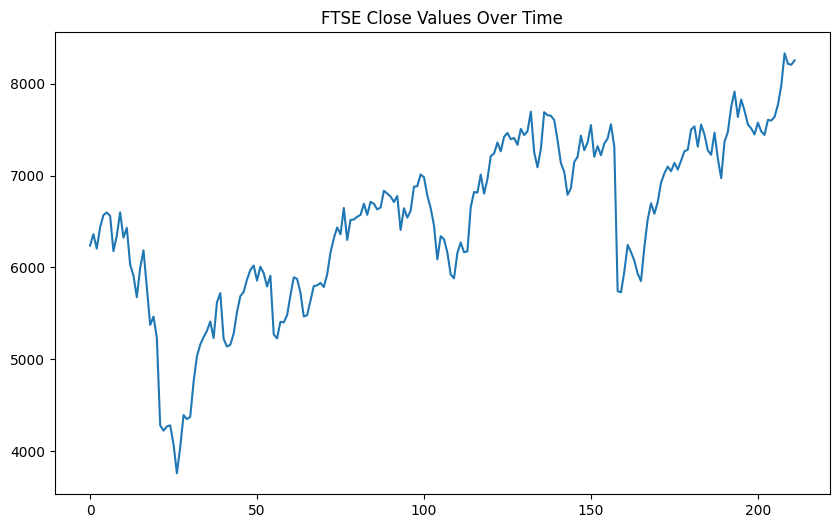

In [50]:
import matplotlib.pyplot as plt

ftse['FTSE.Close'].plot(title="FTSE Close Values Over Time", figsize=(10, 6))
plt.show()


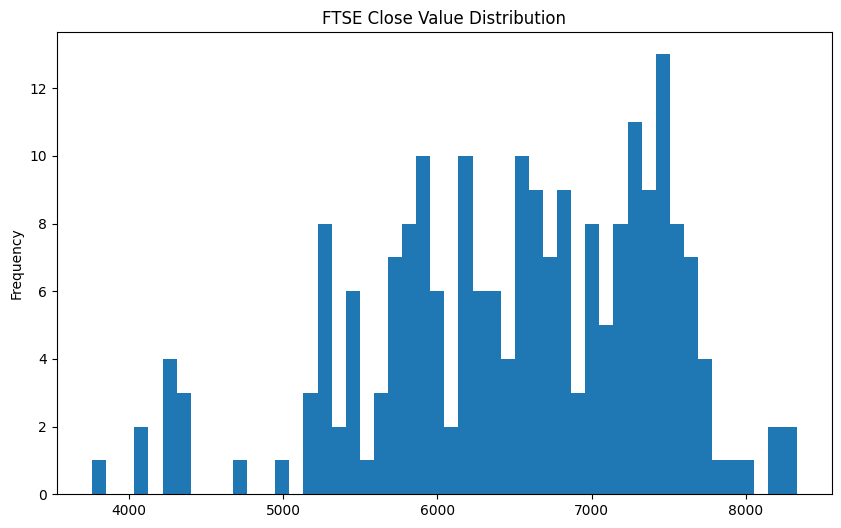

In [51]:
ftse['FTSE.Close'].plot.hist(bins=50, title="FTSE Close Value Distribution", figsize=(10, 6))
plt.show()


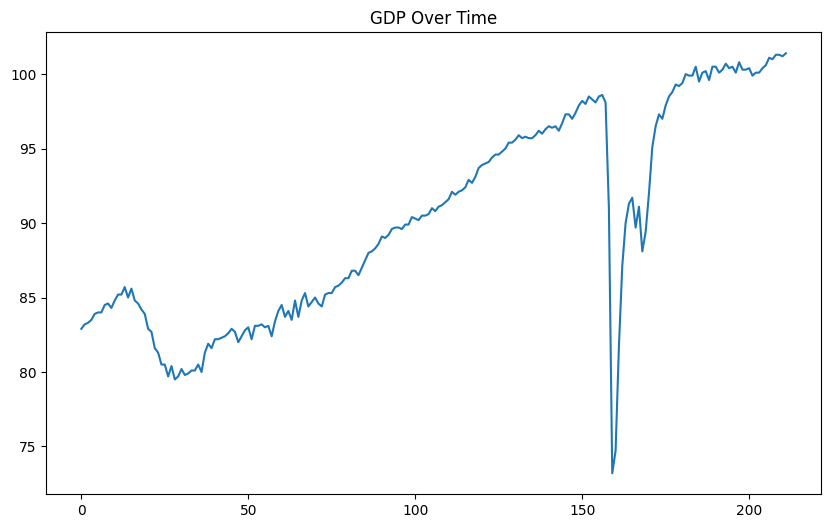

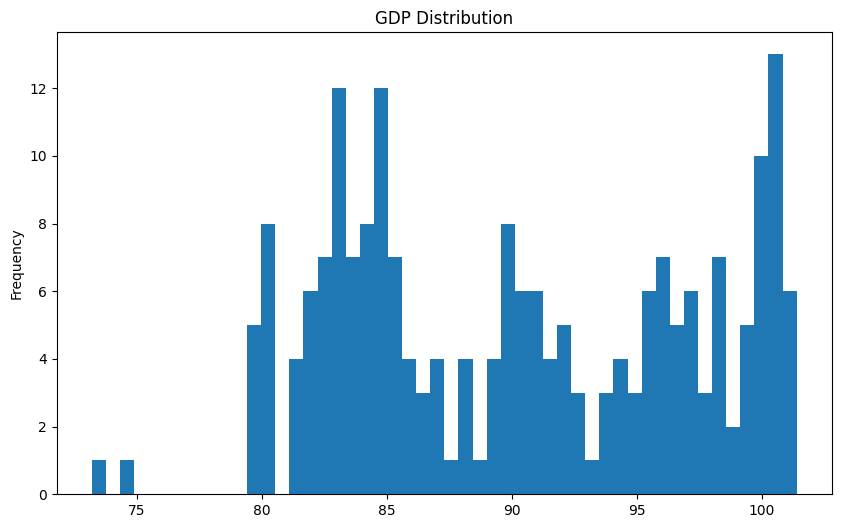

In [52]:
gdp['GDP_Rate'].plot(title="GDP Over Time", figsize=(10, 6))
plt.show()

gdp['GDP_Rate'].plot.hist(bins=50, title="GDP Distribution", figsize=(10, 6))
plt.show()


# Merging Data

In [53]:
merged_data = bank_rate.merge(ftse, on='Date', how='outer')
merged_data = merged_data.merge(cpih, on='Date', how='outer')
merged_data = merged_data.merge(vix, on='Date', how='outer')
merged_data = merged_data.merge(gdp, on='Date', how='outer')
merged_data = merged_data.merge(gbp_usd, on='Date', how='outer')
#log transformation for selected variables
merged_data['FTSE.Close'] = np.log(merged_data['FTSE.Close'])
merged_data['GDP_Rate'] = np.log(merged_data['GDP_Rate'])
merged_data['CPIH_Rate'] = np.log(merged_data['CPIH_Rate'])
merged_data['VIX.Close'] = np.log(merged_data['VIX.Close'])
merged_data['Gbp_usd.Close'] = np.log(merged_data['Gbp_usd.Close'])

merged_data = merged_data.sort_values(by="Date").set_index("Date")

print("Number of missing values (after merging):")
print(merged_data.isnull().sum())
print(merged_data.head())


Number of missing values (after merging):
Bank Rate         0
FTSE.Close        0
CPIH_Rate         0
VIX.Close         0
GDP_Rate          0
Gbp_usd.Close    20
dtype: int64
            Bank Rate  FTSE.Close  CPIH_Rate  VIX.Close  GDP_Rate  \
Date                                                                
2007-01-31   5.170455    8.738381   0.993252   2.401751  4.417635   
2007-02-28   5.250000    8.758207   0.993252   2.411911  4.421247   
2007-03-31   5.250000    8.733225   1.064711   2.718840  4.422449   
2007-04-30   5.250000    8.769407   0.993252   2.559782  4.424847   
2007-05-31   5.428571    8.790235   0.916291   2.587593  4.429626   

            Gbp_usd.Close  
Date                       
2007-01-31       0.672507  
2007-02-28       0.673157  
2007-03-31       0.666681  
2007-04-30       0.687641  
2007-05-31       0.684526  


In [54]:
#Inf values after transformation
print(merged_data.isin([np.inf, -np.inf]).sum())


Bank Rate        0
FTSE.Close       0
CPIH_Rate        0
VIX.Close        0
GDP_Rate         0
Gbp_usd.Close    0
dtype: int64


In [55]:
#Interpolation for missing values
merged_data.interpolate(method='time', inplace=True, limit_direction='forward')


In [56]:
missing_values_after = merged_data.isnull().sum().sum()

if missing_values_after == 0:
    print("No missing data")
else:
    print(f"There are still {missing_values_after} missing values after interpolation.")


No missing data


In [57]:
print(merged_data.describe())

        Bank Rate  FTSE.Close   CPIH_Rate   VIX.Close    GDP_Rate  \
count  212.000000  212.000000  212.000000  212.000000  212.000000   
mean     1.461453    8.770538    0.774965    2.920762    4.499917   
std      1.879539    0.152404    0.746439    0.354265    0.077728   
min      0.100000    8.232237   -1.609438    2.315053    4.293195   
25%      0.500000    8.681089    0.470004    2.647074    4.431709   
50%      0.500000    8.795911    0.875469    2.869245    4.499254   
75%      1.000893    8.892433    1.131402    3.133406    4.570061   
max      5.750000    9.027730    2.261763    4.137396    4.619073   

       Gbp_usd.Close  
count     212.000000  
mean        0.378623  
std         0.146478  
min         0.122048  
25%         0.258569  
50%         0.372303  
75%         0.471205  
max         0.727822  


# Data Exploration

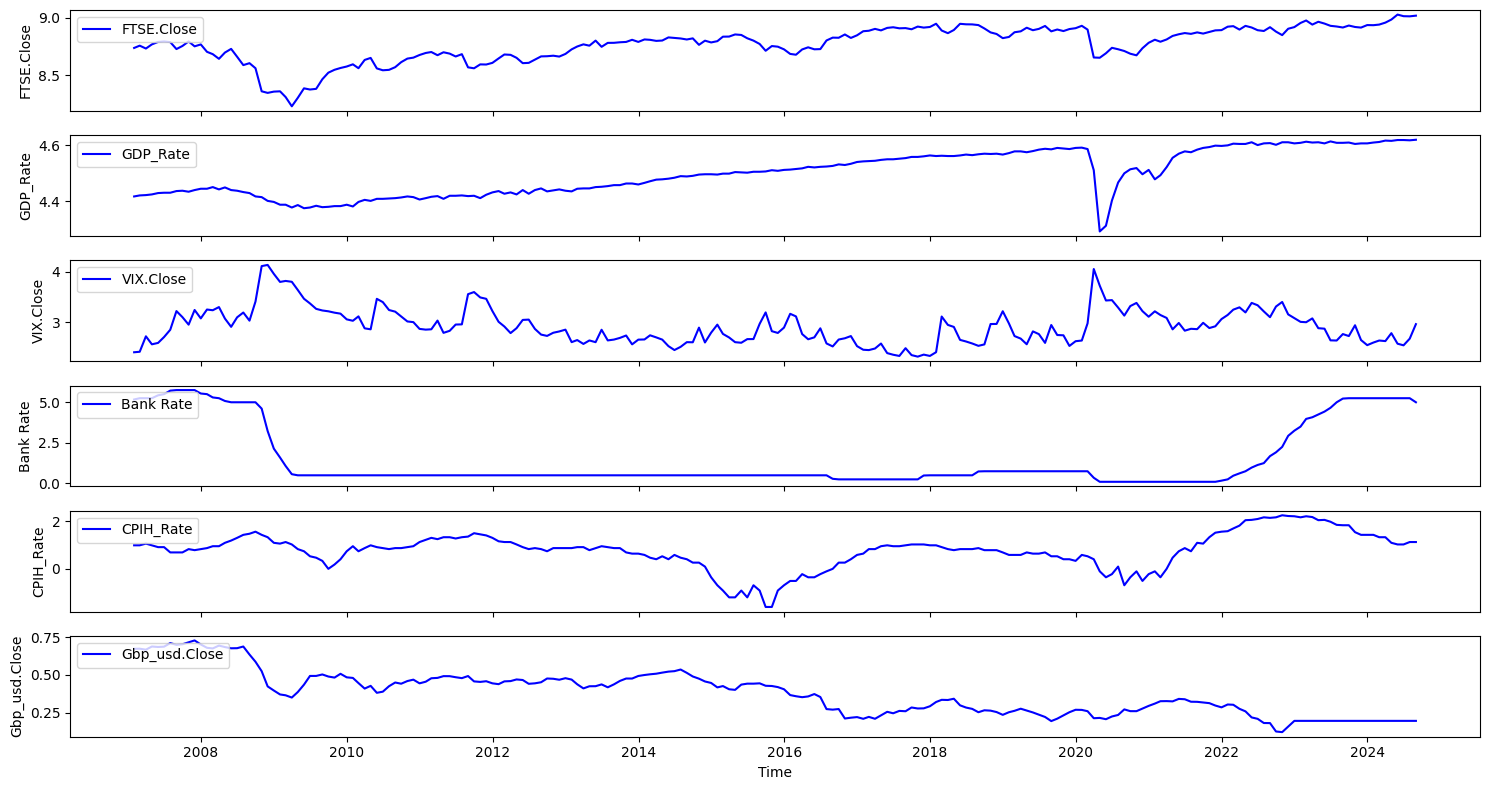

In [58]:
import matplotlib.pyplot as plt

plot_cols = ['FTSE.Close', 'GDP_Rate', 'VIX.Close', 'Bank Rate', 'CPIH_Rate', 'Gbp_usd.Close']

fig, ax = plt.subplots(len(plot_cols), figsize=(15, 8), sharex=True)

for i, col in enumerate(plot_cols):
    ax[i].plot(merged_data.index, merged_data[col], label=col, color='blue')
    ax[i].set_ylabel(col)
    ax[i].legend(loc='upper left')

ax[-1].set_xlabel('Time')

plt.tight_layout()
plt.show()


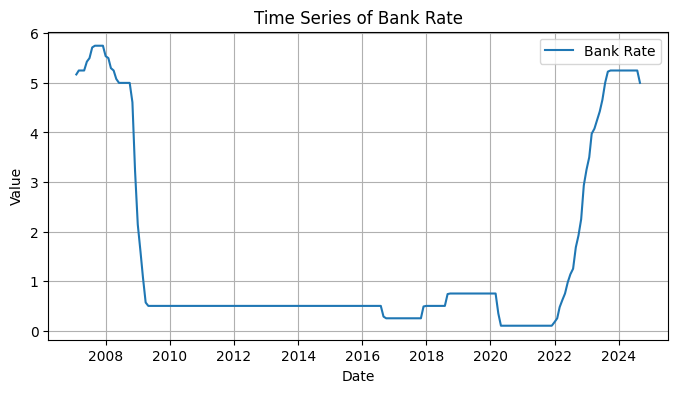

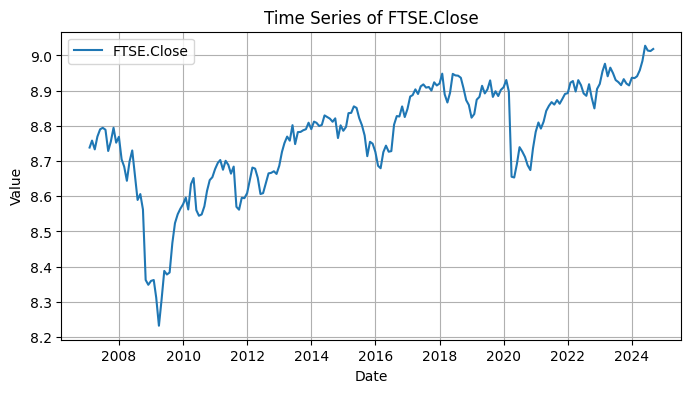

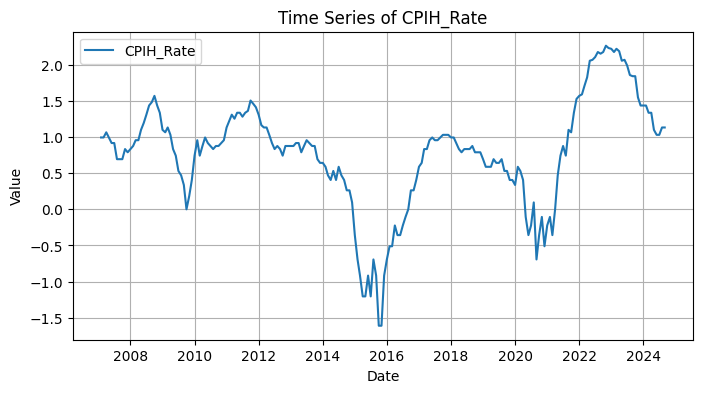

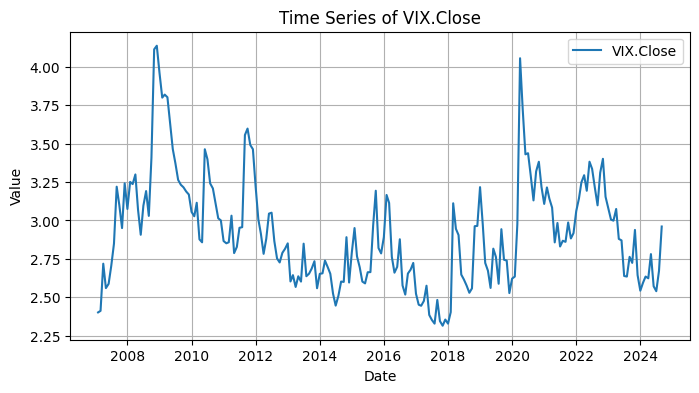

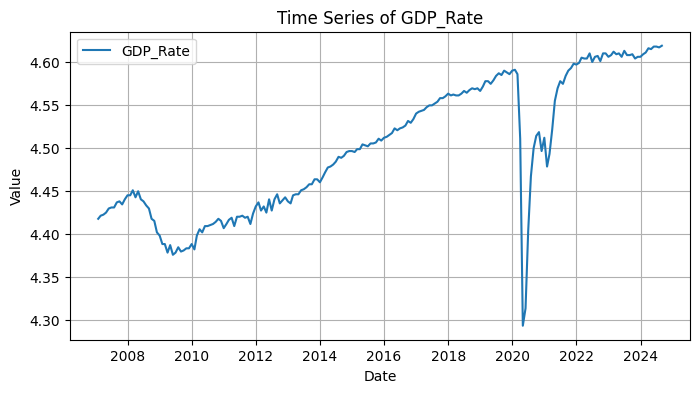

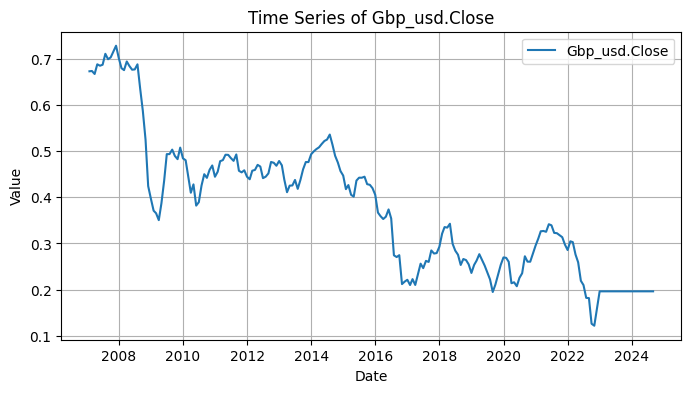

In [59]:
for column in merged_data.columns:
    plt.figure(figsize=(8, 4))
    plt.plot(merged_data.index, merged_data[column], label=column)
    plt.title(f"Time Series of {column}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()
    plt.show()


# Heatmap

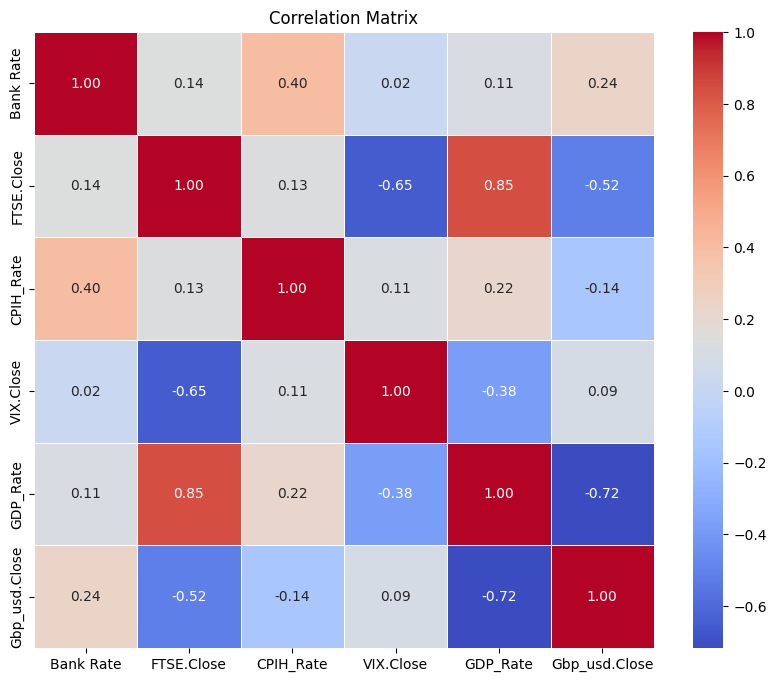

In [60]:
plt.figure(figsize=(10, 8))
correlation_matrix = merged_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Pairplot

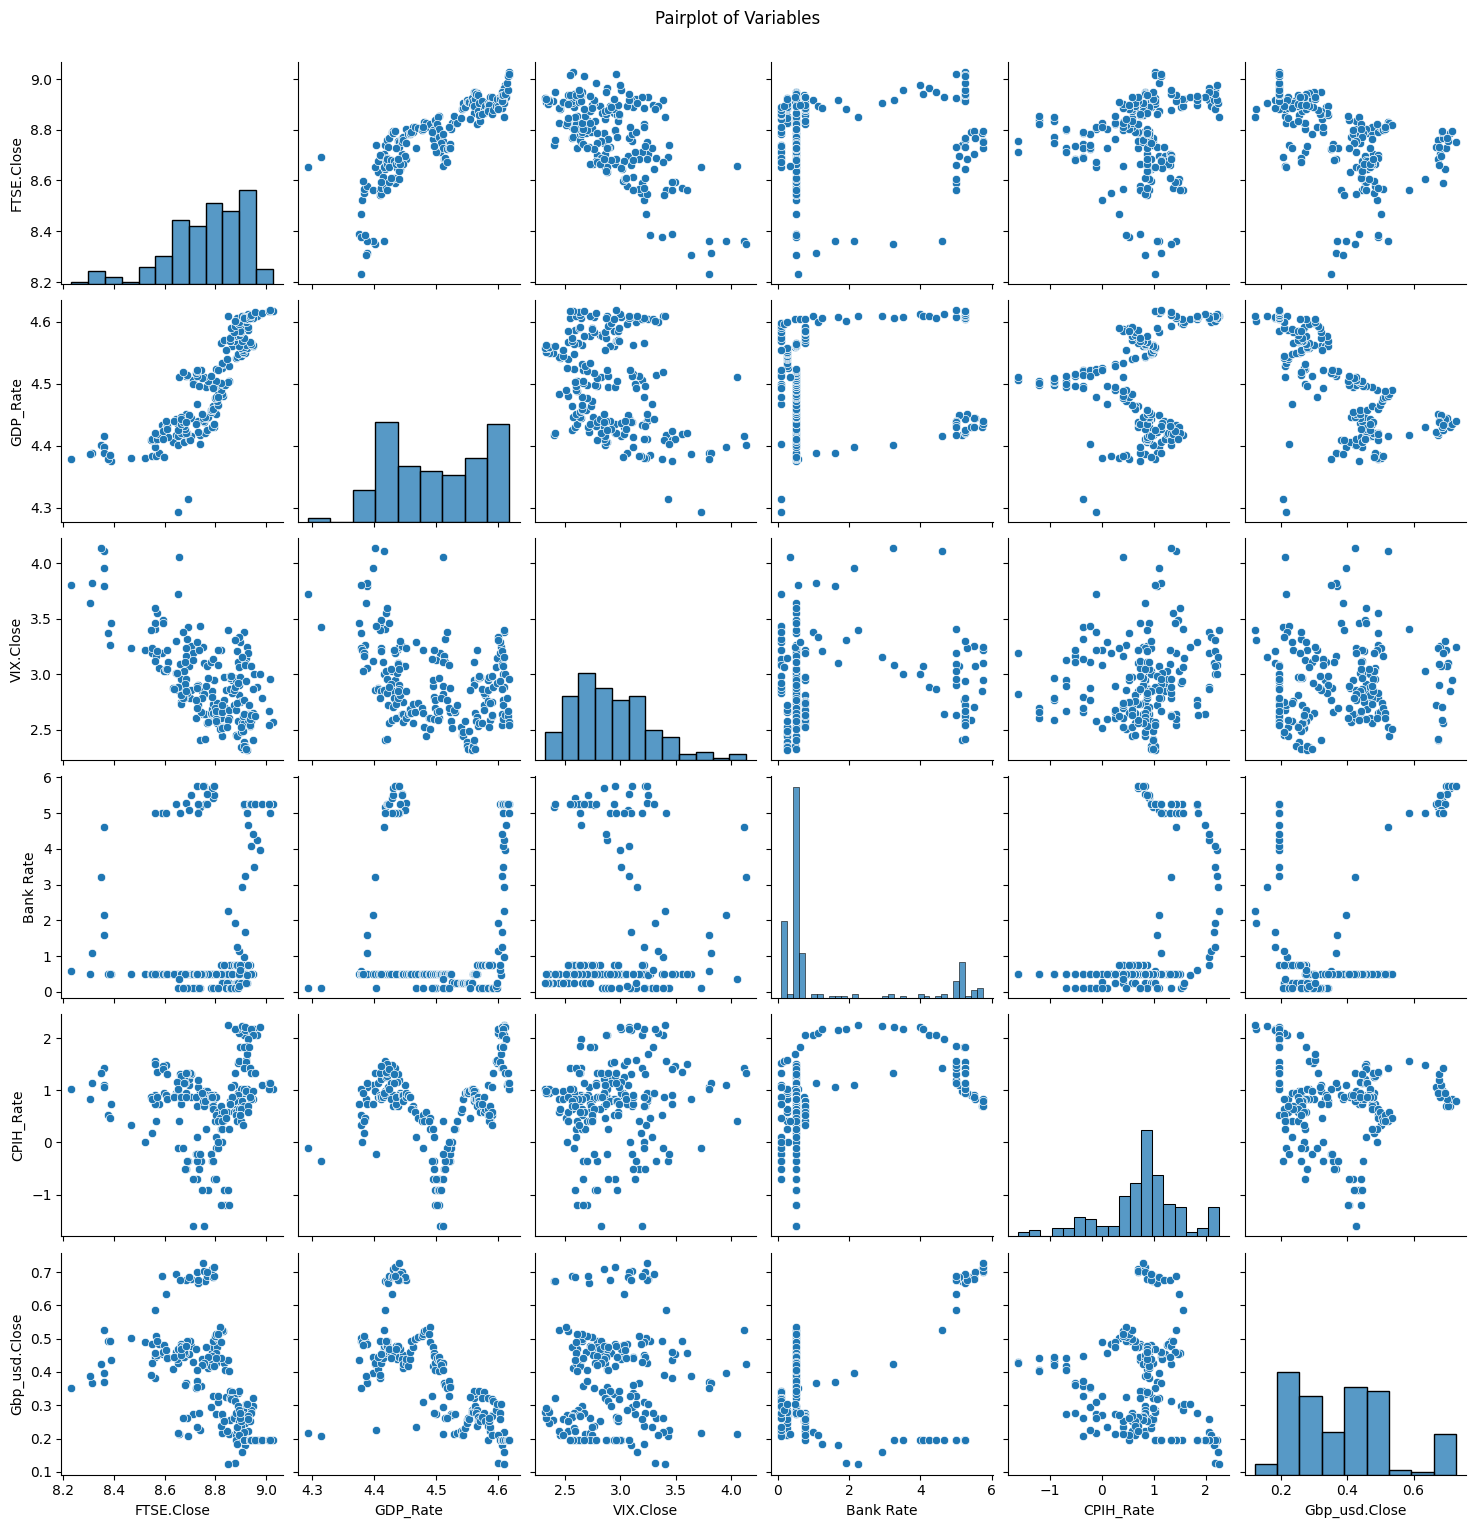

In [61]:
sns.pairplot(merged_data[['FTSE.Close', 'GDP_Rate', 'VIX.Close', 'Bank Rate', 'CPIH_Rate', 'Gbp_usd.Close']])
plt.suptitle("Pairplot of Variables", y=1.02)
plt.show()

# ADF Test

In [62]:
def adf_test_auto(series, name, max_diff=2, verbose=True):
    diff_count = 0
    series = series.interpolate(method='time').dropna()
    while diff_count <= max_diff:
        result = adfuller(series, autolag='AIC')
        p_value = result[1]
        if verbose:
            print(f"ADF Test for {name} (diff_count={diff_count}): p-value = {p_value}")
        if p_value < 0.05:
            if verbose:
                print(f"{name} is stationary after {diff_count} differencing step(s).\n")
            return series
        series = series.diff().dropna()
        diff_count += 1
    if verbose:
        print(f"{name} is not stationary after max differencing ({max_diff}).\n")
    return series


def apply_adf_to_dataframe(df, columns, max_diff=2, verbose=True):
    stationary_data = {}
    for col in columns:
        print(f"Processing {col}...")
        stationary_data[col] = adf_test_auto(df[col], col, max_diff=max_diff, verbose=verbose)
    return pd.DataFrame(stationary_data)


columns_to_test = ['FTSE.Close', 'GDP_Rate', 'VIX.Close', 'Bank Rate', 'CPIH_Rate', 'Gbp_usd.Close']


stationary_data = apply_adf_to_dataframe(merged_data, columns_to_test)
for col in columns_to_test:
    merged_data[col] = stationary_data[col]

merged_data.dropna(inplace=True)


print("Updated Data after ADF Test and Differencing:")
print(merged_data.head(50))
print(merged_data.tail(50))

Processing FTSE.Close...
ADF Test for FTSE.Close (diff_count=0): p-value = 0.6010623573744843
ADF Test for FTSE.Close (diff_count=1): p-value = 1.851848122340703e-20
FTSE.Close is stationary after 1 differencing step(s).

Processing GDP_Rate...
ADF Test for GDP_Rate (diff_count=0): p-value = 0.5851055763580177
ADF Test for GDP_Rate (diff_count=1): p-value = 8.797149019587034e-14
GDP_Rate is stationary after 1 differencing step(s).

Processing VIX.Close...
ADF Test for VIX.Close (diff_count=0): p-value = 0.0006704923809870125
VIX.Close is stationary after 0 differencing step(s).

Processing Bank Rate...
ADF Test for Bank Rate (diff_count=0): p-value = 0.020639015265260227
Bank Rate is stationary after 0 differencing step(s).

Processing CPIH_Rate...
ADF Test for CPIH_Rate (diff_count=0): p-value = 0.08851416287428848
ADF Test for CPIH_Rate (diff_count=1): p-value = 0.006953143101239559
CPIH_Rate is stationary after 1 differencing step(s).

Processing Gbp_usd.Close...
ADF Test for Gbp_us


# Train and Test Split

In [63]:
#in-sample out-sample splitting
train_data = stationary_data[stationary_data.index <= "2022-07-31"]
test_data = stationary_data[stationary_data.index > "2022-07-31"]

print(f"In-Sample Data Shape: {train_data.shape}")
print(f"Out-Sample Data Shape: {test_data.shape}")

In-Sample Data Shape: (187, 6)
Out-Sample Data Shape: (25, 6)


In [64]:
print(train_data.isnull().sum())
print(train_data.isin([np.inf, -np.inf]).sum())


FTSE.Close       1
GDP_Rate         1
VIX.Close        0
Bank Rate        0
CPIH_Rate        1
Gbp_usd.Close    1
dtype: int64
FTSE.Close       0
GDP_Rate         0
VIX.Close        0
Bank Rate        0
CPIH_Rate        0
Gbp_usd.Close    0
dtype: int64


In [65]:
train_data = train_data.fillna(method='bfill').fillna(method='ffill')

# Checking nan values
print(train_data.isnull().sum())
print(train_data.head())

FTSE.Close       0
GDP_Rate         0
VIX.Close        0
Bank Rate        0
CPIH_Rate        0
Gbp_usd.Close    0
dtype: int64
            FTSE.Close  GDP_Rate  VIX.Close  Bank Rate  CPIH_Rate  \
Date                                                                
2007-01-31    0.019825  0.003612   2.401751   5.170455   0.000000   
2007-02-28    0.019825  0.003612   2.411911   5.250000   0.000000   
2007-03-31   -0.024982  0.001201   2.718840   5.250000   0.071459   
2007-04-30    0.036182  0.002398   2.559782   5.250000  -0.071459   
2007-05-31    0.020828  0.004779   2.587593   5.428571  -0.076961   

            Gbp_usd.Close  
Date                       
2007-01-31       0.000650  
2007-02-28       0.000650  
2007-03-31      -0.006476  
2007-04-30       0.020961  
2007-05-31      -0.003115  


<ipython-input-65-7abf7c1c9a91>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_data = train_data.fillna(method='bfill').fillna(method='ffill')


In [66]:
for col in train_data.columns:
    adf_result = adfuller(train_data[col].dropna())
    print(f"{col}: p-value = {adf_result[1]}")


FTSE.Close: p-value = 8.193976955010286e-19
GDP_Rate: p-value = 1.835186220928125e-12
VIX.Close: p-value = 0.0021454688261792827
Bank Rate: p-value = 0.0013100851031295428
CPIH_Rate: p-value = 0.024242831515444308
Gbp_usd.Close: p-value = 2.693575600457064e-07


# Correlation Matrix

In [67]:
correlation_matrix = train_data.corr()
print(correlation_matrix)


               FTSE.Close  GDP_Rate  VIX.Close  Bank Rate  CPIH_Rate  \
FTSE.Close       1.000000  0.165179  -0.366323  -0.158292   0.114920   
GDP_Rate         0.165179  1.000000  -0.182400  -0.028244   0.248686   
VIX.Close       -0.366323 -0.182400   1.000000   0.138226  -0.140220   
Bank Rate       -0.158292 -0.028244   0.138226   1.000000   0.000141   
CPIH_Rate        0.114920  0.248686  -0.140220   0.000141   1.000000   
Gbp_usd.Close    0.203227  0.087810  -0.234727  -0.123510  -0.040559   

               Gbp_usd.Close  
FTSE.Close          0.203227  
GDP_Rate            0.087810  
VIX.Close          -0.234727  
Bank Rate          -0.123510  
CPIH_Rate          -0.040559  
Gbp_usd.Close       1.000000  


# ACF and PACF'S

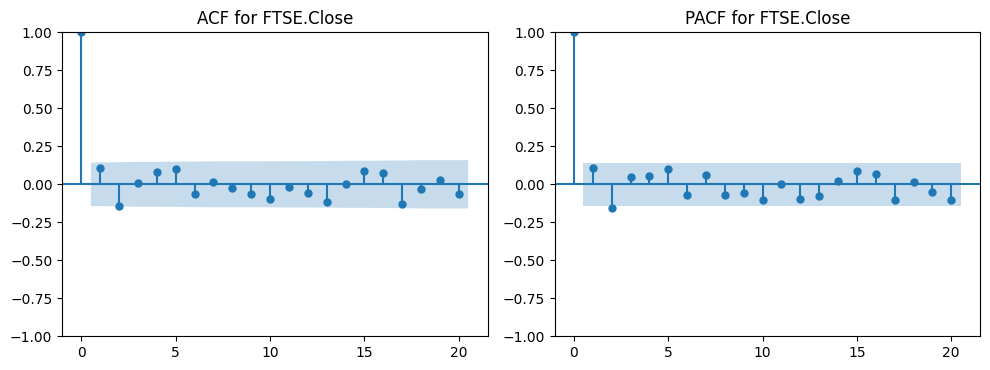

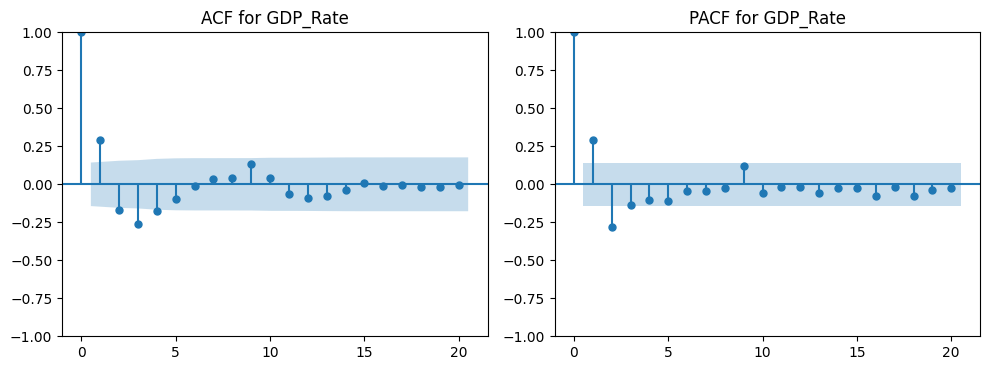

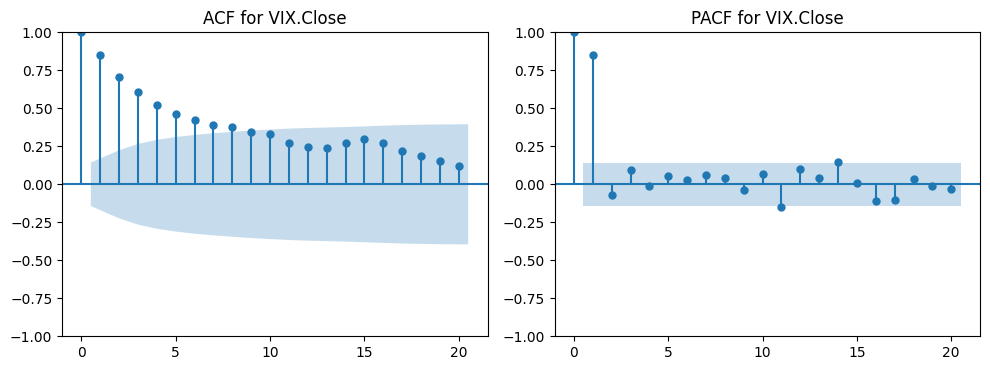

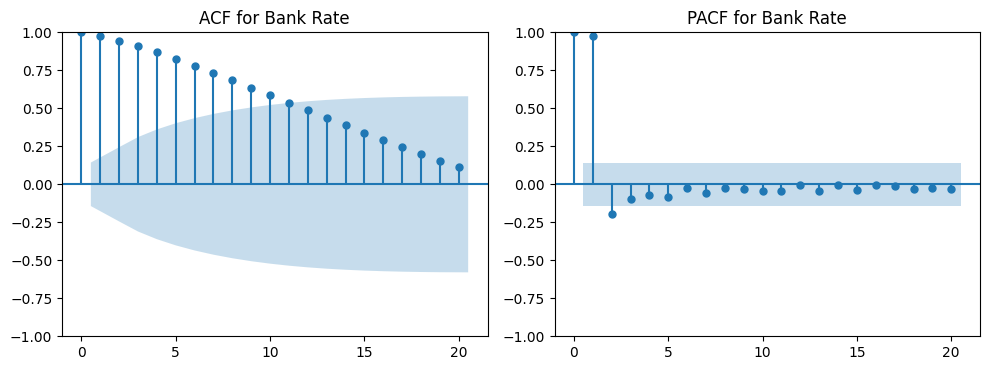

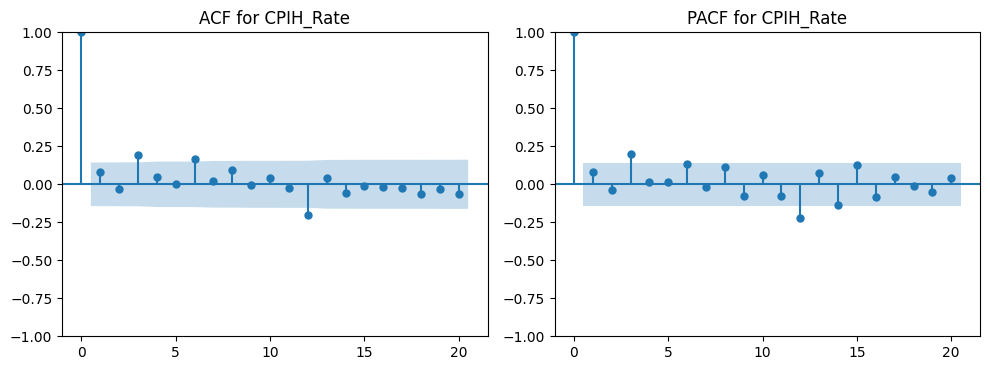

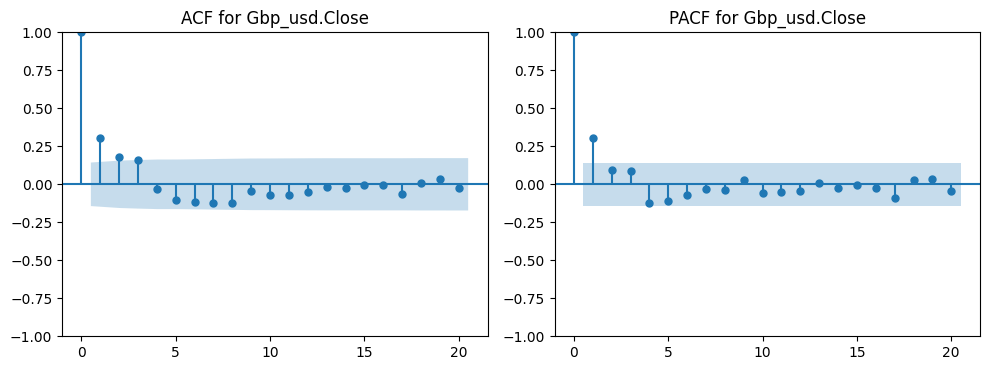

In [68]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF and PACF
for column in train_data.columns:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    plot_acf(train_data[column], lags=20, ax=axes[0], title=f"ACF for {column}")
    plot_pacf(train_data[column], lags=20, ax=axes[1], title=f"PACF for {column}")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



# Vector Autoregression Model

In [69]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
import pandas as pd

# VAR model and lag
model = VAR(train_data)
lag_selection = model.select_order(maxlags=15)
best_lag = lag_selection.aic
print(f"Best Lag (AIC): {best_lag}")

var_model = model.fit(best_lag)
print(var_model.summary())


Best Lag (AIC): 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 31, Jan, 2025
Time:                     17:44:12
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -33.4328
Nobs:                     185.000    HQIC:                  -34.2403
Log likelihood:           1721.11    FPE:                7.78479e-16
AIC:                     -34.7906    Det(Omega_mle):     5.17948e-16
--------------------------------------------------------------------
Results for equation FTSE.Close
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.032048         0.028034           -1.143           0.253
L1.FTSE.Close           -0.027970         0.125879           -0.222           0.824
L1.GDP_Rate              

# Ljungbox Test

In [70]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung Box Test
for col in var_model.resid.columns:
    print(f"Ljung-Box Test for {col}:")
    print(acorr_ljungbox(var_model.resid[col], lags=[best_lag], return_df=True))


Ljung-Box Test for FTSE.Close:
    lb_stat  lb_pvalue
2  0.033351   0.983463
Ljung-Box Test for GDP_Rate:
    lb_stat  lb_pvalue
2  0.525745    0.76884
Ljung-Box Test for VIX.Close:
    lb_stat  lb_pvalue
2  0.114185   0.944507
Ljung-Box Test for Bank Rate:
    lb_stat  lb_pvalue
2  1.868488   0.392883
Ljung-Box Test for CPIH_Rate:
    lb_stat  lb_pvalue
2  0.186328   0.911044
Ljung-Box Test for Gbp_usd.Close:
    lb_stat  lb_pvalue
2  0.180729   0.913598


# Impulse Response

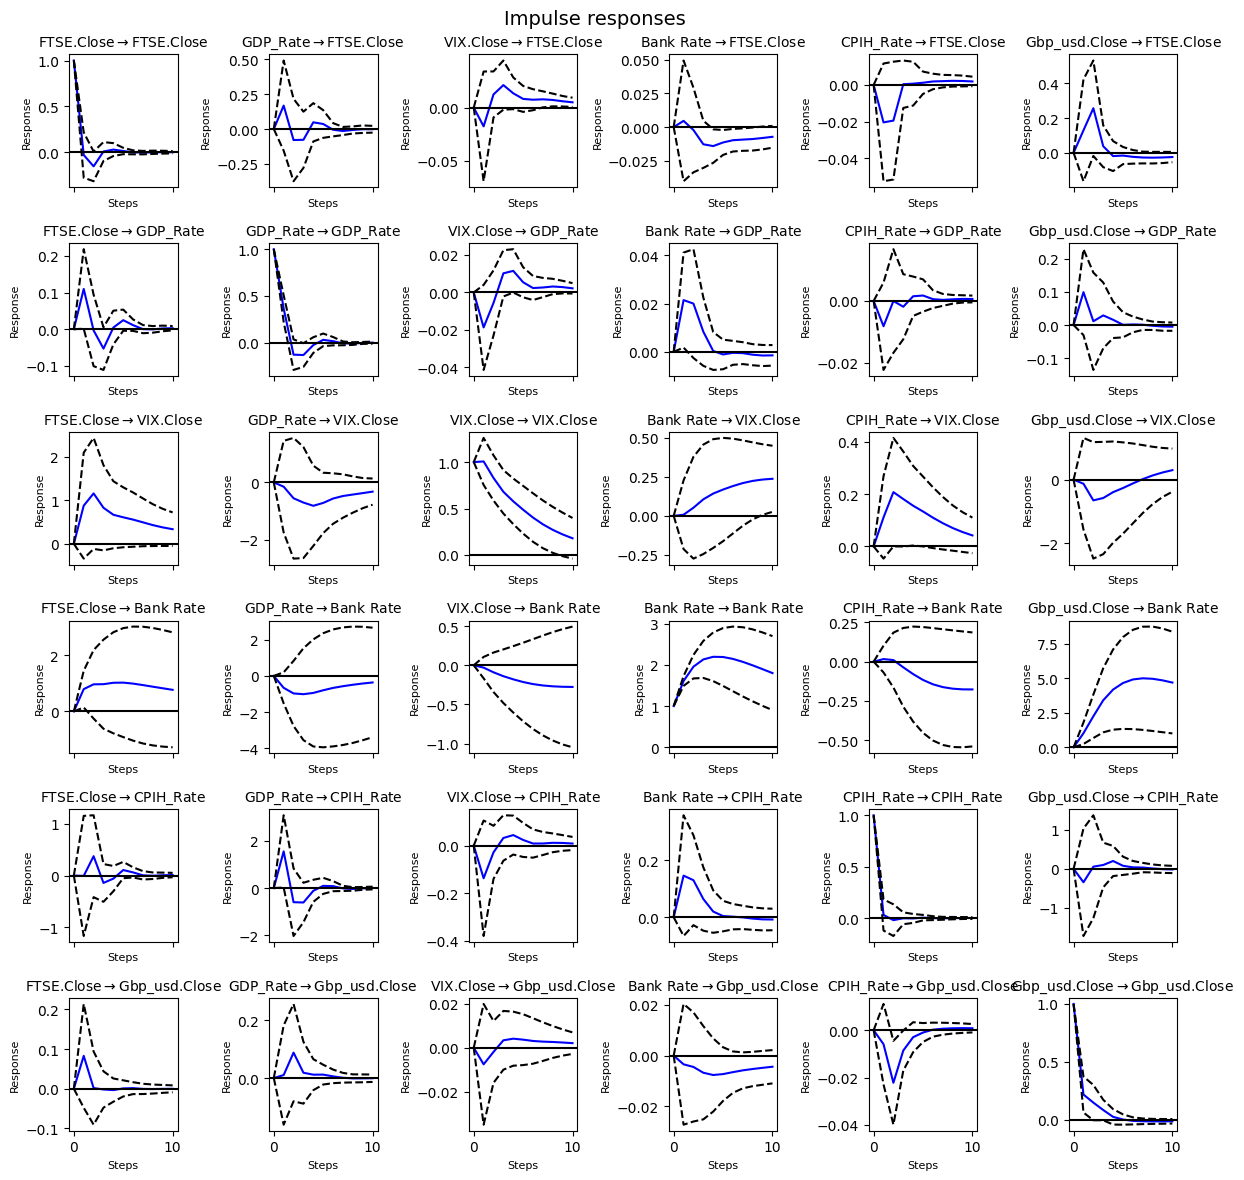

In [71]:
# IRF
irf = var_model.irf(10)
fig = irf.plot(orth=False)


fig.set_size_inches(12, 12)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, ax in enumerate(fig.axes):
    ax.set_title(ax.get_title().replace("→", " impacts "), fontsize=10)
    ax.set_xlabel("Steps", fontsize=8)
    ax.set_ylabel("Response", fontsize=8)

plt.tight_layout()
plt.show()



# Granger Causality Tests

In [72]:
from statsmodels.tsa.stattools import grangercausalitytests

important_pairs = [("FTSE.Close", "VIX.Close"), ("FTSE.Close", "Bank Rate"), ("FTSE.Close", "GDP_Rate"), ("FTSE.Close", "CPIH_Rate"),("FTSE.Close", "Gbp_usd.Close")]
for pair in important_pairs:
    print(f"Granger Causality Test for {pair[0]} and {pair[1]}:")
    grangercausalitytests(train_data[[pair[0], pair[1]]], maxlag=best_lag)



Granger Causality Test for FTSE.Close and VIX.Close:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1075  , p=0.1483  , df_denom=183, df_num=1
ssr based chi2 test:   chi2=2.1420  , p=0.1433  , df=1
likelihood ratio test: chi2=2.1298  , p=0.1445  , df=1
parameter F test:         F=2.1075  , p=0.1483  , df_denom=183, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3281  , p=0.2676  , df_denom=180, df_num=2
ssr based chi2 test:   chi2=2.7300  , p=0.2554  , df=2
likelihood ratio test: chi2=2.7101  , p=0.2579  , df=2
parameter F test:         F=1.3281  , p=0.2676  , df_denom=180, df_num=2
Granger Causality Test for FTSE.Close and Bank Rate:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4920  , p=0.0202  , df_denom=183, df_num=1
ssr based chi2 test:   chi2=5.5820  , p=0.0181  , df=1
likelihood ratio test: chi2=5.4999  , p=0.0190  , df=1
parameter F test:         F=5.4920  , p=0.0202  , df_denom=18

In [73]:
from statsmodels.tsa.stattools import grangercausalitytests

# granger causality test for FTSE.Close
all_ftse_pairs = [(var, "FTSE.Close") for var in train_data.columns if var != "FTSE.Close"]

for pair in all_ftse_pairs:
    print(f"\nGranger Causality Test for {pair[0]} and {pair[1]}:")
    try:
        grangercausalitytests(train_data[[pair[0], pair[1]]], maxlag=best_lag)
    except KeyError as e:
        print(f"Error: {e}. Check if the variables are present in the dataset.")



Granger Causality Test for GDP_Rate and FTSE.Close:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=37.4053 , p=0.0000  , df_denom=183, df_num=1
ssr based chi2 test:   chi2=38.0185 , p=0.0000  , df=1
likelihood ratio test: chi2=34.5926 , p=0.0000  , df=1
parameter F test:         F=37.4053 , p=0.0000  , df_denom=183, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=19.3427 , p=0.0000  , df_denom=180, df_num=2
ssr based chi2 test:   chi2=39.7600 , p=0.0000  , df=2
likelihood ratio test: chi2=36.0153 , p=0.0000  , df=2
parameter F test:         F=19.3427 , p=0.0000  , df_denom=180, df_num=2

Granger Causality Test for VIX.Close and FTSE.Close:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0527  , p=0.8188  , df_denom=183, df_num=1
ssr based chi2 test:   chi2=0.0535  , p=0.8171  , df=1
likelihood ratio test: chi2=0.0535  , p=0.8171  , df=1
parameter F test:         F=0.0527  , p=0.8188  , df_denom=1

# Forecast

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 31, Jan, 2025
Time:                     17:44:17
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -33.4328
Nobs:                     185.000    HQIC:                  -34.2403
Log likelihood:           1721.11    FPE:                7.78479e-16
AIC:                     -34.7906    Det(Omega_mle):     5.17948e-16
--------------------------------------------------------------------
Results for equation FTSE.Close
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.032048         0.028034           -1.143           0.253
L1.FTSE.Close           -0.027970         0.125879           -0.222           0.824
L1.GDP_Rate              0.168188         0

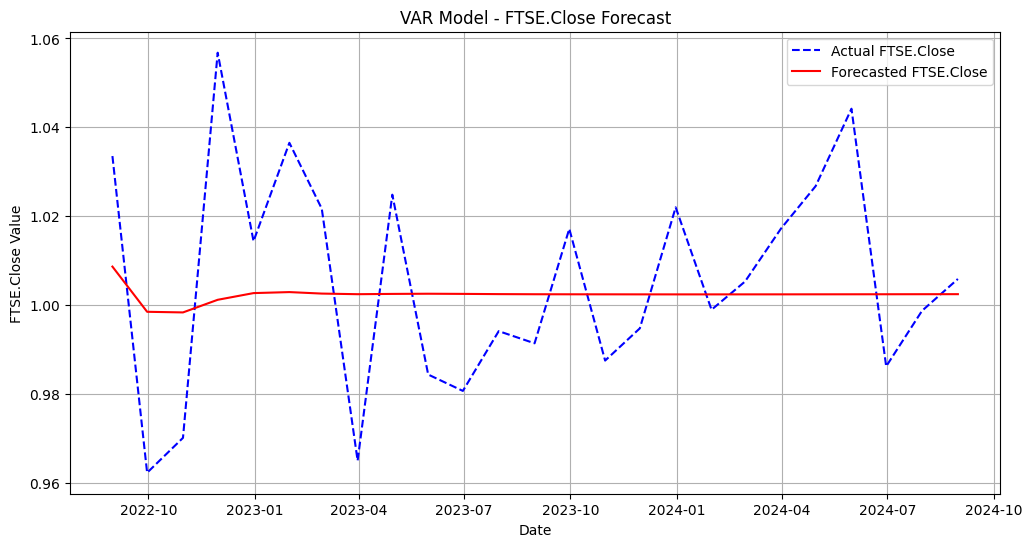

In [74]:
# Train and Test datasets
selected_columns = ["FTSE.Close", "GDP_Rate", "Bank Rate", "CPIH_Rate", "Gbp_usd.Close", "VIX.Close"]
train_data_selected = train_data[selected_columns]
test_data_selected = test_data[selected_columns]

# VAR model
var_model = VAR(train_data_selected)

var_fit = var_model.fit(2)  # Choosen lag
print(var_fit.summary())

# Out-sample forecast
forecast_steps = len(test_data_selected)
forecast = var_fit.forecast(train_data_selected.values[-best_lag:], steps=forecast_steps)


# Dataframe for forecast
forecast_df = pd.DataFrame(forecast, columns=test_data_selected.columns, index=test_data_selected.index)
forecast_df['FTSE.Close'] = np.exp(forecast_df['FTSE.Close'])
test_data_selected['FTSE.Close'] = np.exp(test_data_selected['FTSE.Close'])


# Performance metrics
mse = mean_squared_error(test_data_selected["FTSE.Close"], forecast_df["FTSE.Close"])
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_selected["FTSE.Close"], forecast_df["FTSE.Close"])
r2 = r2_score(test_data_selected["FTSE.Close"], forecast_df["FTSE.Close"])

print(f"Out-Sample MSE: {mse}")
print(f"Out-Sample RMSE: {rmse}")
print(f"Out-Sample MAE: {mae}")
print(f"Out-Sample R²: {r2}")

# Visualisation
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_data_selected.index, test_data_selected["FTSE.Close"], label="Actual FTSE.Close", linestyle='--', color='blue')
plt.plot(forecast_df.index, forecast_df["FTSE.Close"], label="Forecasted FTSE.Close", linestyle='-', color='red')
plt.title("VAR Model - FTSE.Close Forecast")
plt.xlabel("Date")
plt.ylabel("FTSE.Close Value")
plt.legend()
plt.grid()
plt.show()


In [75]:
lag_order = var_model.select_order(maxlags=15)
print(lag_order.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -27.74      -27.63   8.944e-13      -27.70
1       -34.15     -33.39*   1.468e-15      -33.84
2      -34.71*      -33.28  8.433e-16*     -34.13*
3       -34.60      -32.52   9.422e-16      -33.76
4       -34.59      -31.85   9.579e-16      -33.48
5       -34.49      -31.08   1.078e-15      -33.11
6       -34.49      -30.42   1.097e-15      -32.84
7       -34.32      -29.60   1.322e-15      -32.41
8       -34.14      -28.76   1.641e-15      -31.96
9       -33.99      -27.95   1.998e-15      -31.54
10      -33.90      -27.20   2.294e-15      -31.18
11      -34.03      -26.67   2.161e-15      -31.04
12      -34.11      -26.10   2.161e-15      -30.86
13      -34.01      -25.34   2.643e-15      -30.49
14      -34.08      -24.75   2.790e-15      -30.29
15      -34.18      -24.19   2.931e-15      -30.13
-------------------------------

# In-sample

In-Sample MSE: 0.001343028169856552
In-Sample RMSE: 0.03664734874252914
In-Sample MAE: 0.026172326629744537
In-Sample R²: 0.1379793953652816


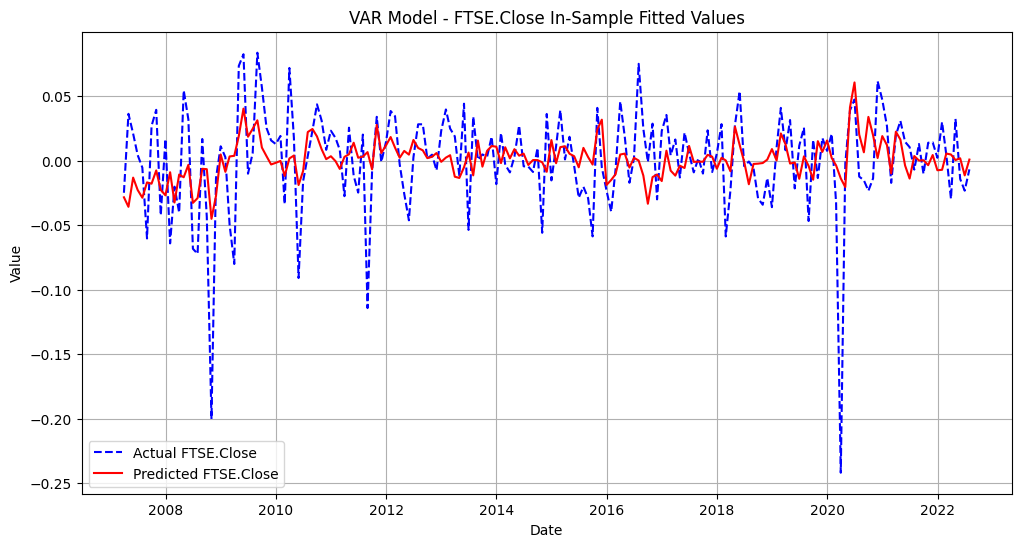

In [76]:
# Model
var_fit = var_model.fit(best_lag)  # Best lag from previous

# In-sample forecasts
in_sample_predictions = var_fit.fittedvalues
adjusted_train_data = train_data.iloc[best_lag:]

# Performance metrics
in_sample_mse = mean_squared_error(adjusted_train_data["FTSE.Close"], in_sample_predictions["FTSE.Close"])
in_sample_rmse = np.sqrt(in_sample_mse)
in_sample_mae = mean_absolute_error(adjusted_train_data["FTSE.Close"], in_sample_predictions["FTSE.Close"])
in_sample_r2 = r2_score(adjusted_train_data["FTSE.Close"], in_sample_predictions["FTSE.Close"])

print(f"In-Sample MSE: {in_sample_mse}")
print(f"In-Sample RMSE: {in_sample_rmse}")
print(f"In-Sample MAE: {in_sample_mae}")
print(f"In-Sample R²: {in_sample_r2}")

#Visualisations
plt.figure(figsize=(12, 6))
plt.plot(adjusted_train_data.index, adjusted_train_data["FTSE.Close"], label="Actual FTSE.Close", linestyle='--', color='blue')
plt.plot(in_sample_predictions.index, in_sample_predictions["FTSE.Close"], label="Predicted FTSE.Close", color='red')
plt.title("VAR Model - FTSE.Close In-Sample Fitted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid()
plt.show()
